In [15]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import sbibm
import torch

from sbi.analysis import pairplot

plt.style.use('../plotting_settings.mplstyle')
# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

BASE_DIR = Path.cwd().parent.parent
save_folder = BASE_DIR / "data/results"

In [16]:
# Get benchmark task to load observations
seed = torch.randint(100000, (1,)).item()

task = sbibm.get_task("ddm")
prior = task.get_prior_dist()
simulator = task.get_simulator(seed=seed) # Passing the seed to Julia.

In [28]:
with open(save_folder / "lan_10_11_posterior_samples_100x100iid.p", "rb") as fh:
    samples = pickle.load(fh)
samples_lan_11 = torch.stack(samples)

with open(save_folder / "lan_10_11_posterior_samples_100x100iid_old.p", "rb") as fh:
    samples_lan_old = torch.stack(pickle.load(fh))

with open(save_folder / "mnle_100000_posterior_samples_100x100iid_Old.p", "rb") as fh:
    samples_mnle_old = torch.tensor(pickle.load(fh))

with open(save_folder / "lan_10_5_ours_posterior_samples_100x100iid.p", "rb") as fh:
    samples = pickle.load(fh)
samples_lan_5 = torch.stack(samples)

with open(save_folder / "lan_10_8_ours_posterior_samples_100x100iid_new.p", "rb") as fh:
    samples = pickle.load(fh)
samples_lan_8 = torch.stack(samples)

with open(save_folder / "mnle_100000_posterior_samples_100x100iid.p", "rb") as fh:
    samples = pickle.load(fh)
samples_mnle_5 = torch.stack(samples)

with open(save_folder / "mnle-2_100000_posterior_samples_100x100iid.p", "rb") as fh:
    samples = pickle.load(fh)
samples_mnle_2_5 = torch.stack(samples)

In [24]:
def plot_bar(pos, metrics, label, color, alpha=.6):
    plt.bar(
            pos, 
            height=metrics.mean(0), 
            width=width,
            yerr=metrics.std(0) / np.sqrt(metrics.shape[0]), 
            color = color,
            label=label,
            alpha=alpha,
            )
    

In [25]:
varerr = np.zeros((100, 2))
true_samples = torch.zeros(100, 1000, 4)
true_thetas = torch.zeros(100, 4)

for obsi in range(100):
    true_samples[obsi,] = task.get_reference_posterior_samples(201+obsi)[:1000]
    true_thetas[obsi,] = task.get_true_parameters(201+obsi)


In [29]:
metrics_lan_11 = torch.zeros(3, 100, 4)
metrics_lan_5 = torch.zeros_like(metrics_lan_11)
metrics_lan_8 = torch.zeros_like(metrics_lan_11)
metrics_lan_old = torch.zeros_like(metrics_lan_11)

metrics_mnle_5 = torch.zeros_like(metrics_lan_11)
metrics_mnle_2_5 = torch.zeros_like(metrics_lan_11)
metrics_mnle_old = torch.zeros_like(metrics_lan_11)

reference_estimation_error = (true_thetas - true_samples.mean(1))**2
# mean error
for m, s in zip(
    [metrics_lan_11, metrics_lan_5, metrics_lan_8, metrics_lan_old, metrics_mnle_5, metrics_mnle_2_5, metrics_mnle_old], 
    [samples_lan_11, samples_lan_5, samples_lan_8, samples_lan_old, samples_mnle_5, samples_mnle_2_5, samples_mnle_old]):
    m[0, :, :] = abs(true_samples.mean(1) - s.mean(1)) 
    m[1, :, :] = abs(true_samples.var(1) - s.var(1))
    m[2, :, :] = (true_thetas - s.mean(1))**2

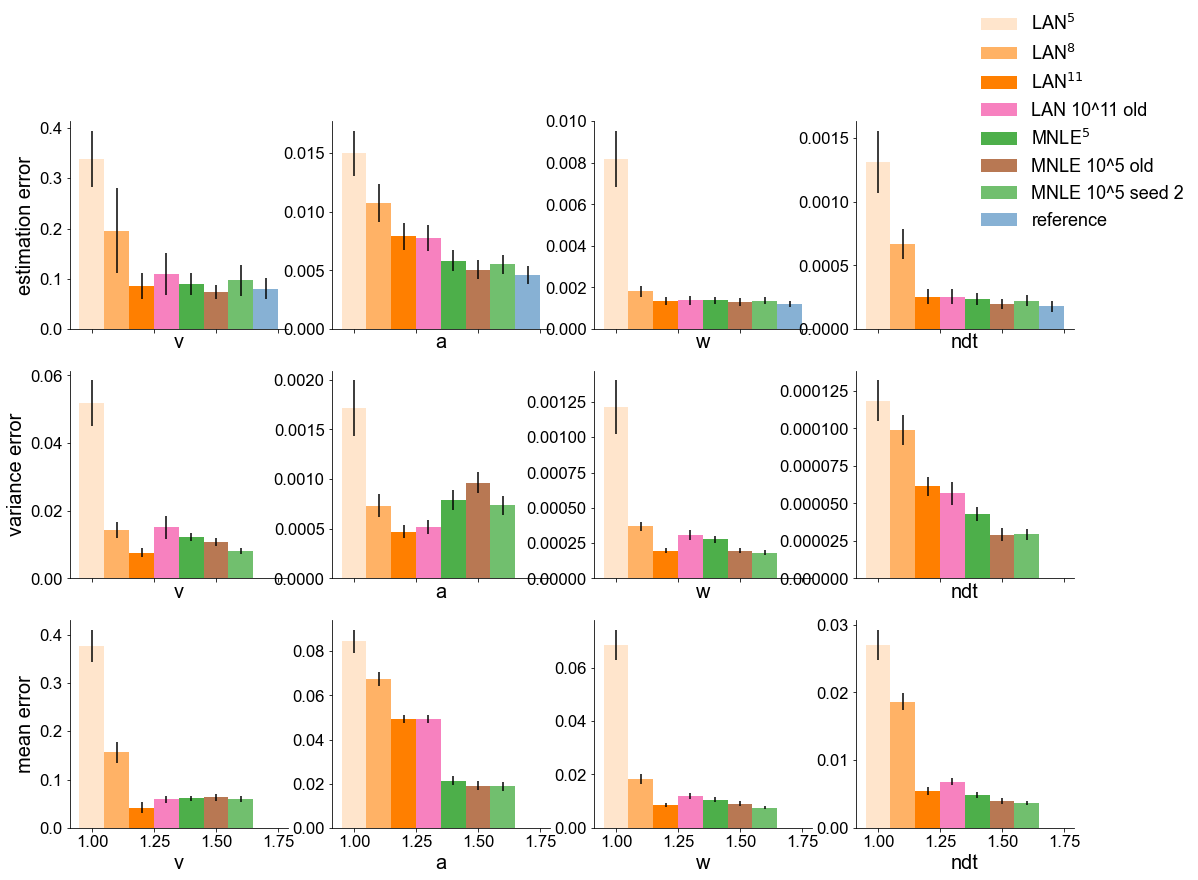

In [30]:
fig, ax = plt.subplots(3, 4, figsize=(18, 13), sharey=False, sharex=True)
xlabels = ["v", "a", "w", "ndt"]
ylabels = ["mean error", "variance error", "estimation error"]
width = 0.1
pos = 1.

for jj in range(3):  # metrics
    for ii in range(4):  # params
        plt.sca(ax[-jj-1, ii])
        plot_bar(pos, metrics_lan_5[jj, :, ii], label=r"LAN$^5$", color=colors[1], alpha=.2)
        plot_bar(pos+0.1, metrics_lan_8[jj, :, ii], label=r"LAN$^{8}$", color=colors[1], alpha=0.6)
        plot_bar(pos+0.2, metrics_lan_11[jj, :, ii], label=r"LAN$^{11}$", color=colors[1], alpha=1.0)
        plot_bar(pos+0.3, metrics_lan_old[jj, :, ii], label="LAN 10^11 old", color=colors[3], alpha=1)
        plot_bar(pos+0.4, metrics_mnle_5[jj, :, ii], label=r"MNLE$^5$", color=colors[2], alpha=1)
        plot_bar(pos+0.5, metrics_mnle_old[jj, :, ii], label="MNLE 10^5 old", color=colors[4], alpha=.8)
        plot_bar(pos+0.6, metrics_mnle_2_5[jj, :, ii], label="MNLE 10^5 seed 2", color=colors[2], alpha=.8)
#         plot_bar(pos+0.4, metrics_mnle_2_5[jj, :, ii], label="MNLE 10^5 seed 2", color=colors[2], alpha=.6)
        if jj==2:
            plot_bar(pos+0.7, reference_estimation_error[:, ii], label="reference", color=colors[0])
        # plt.xticks([])
        plt.xlabel(xlabels[ii])
        if ii==3 and jj==2:
            plt.legend(
                bbox_to_anchor=(.5, .4)
                )
        if ii==0:
            plt.ylabel(ylabels[jj])

In [24]:
metrics_lan_11.mean(2).mean(1), metrics_mnle_2_5.mean(2).mean(1)

(tensor([0.5152, 0.2682, 0.0236]), tensor([0.3600, 0.1806, 0.0279]))

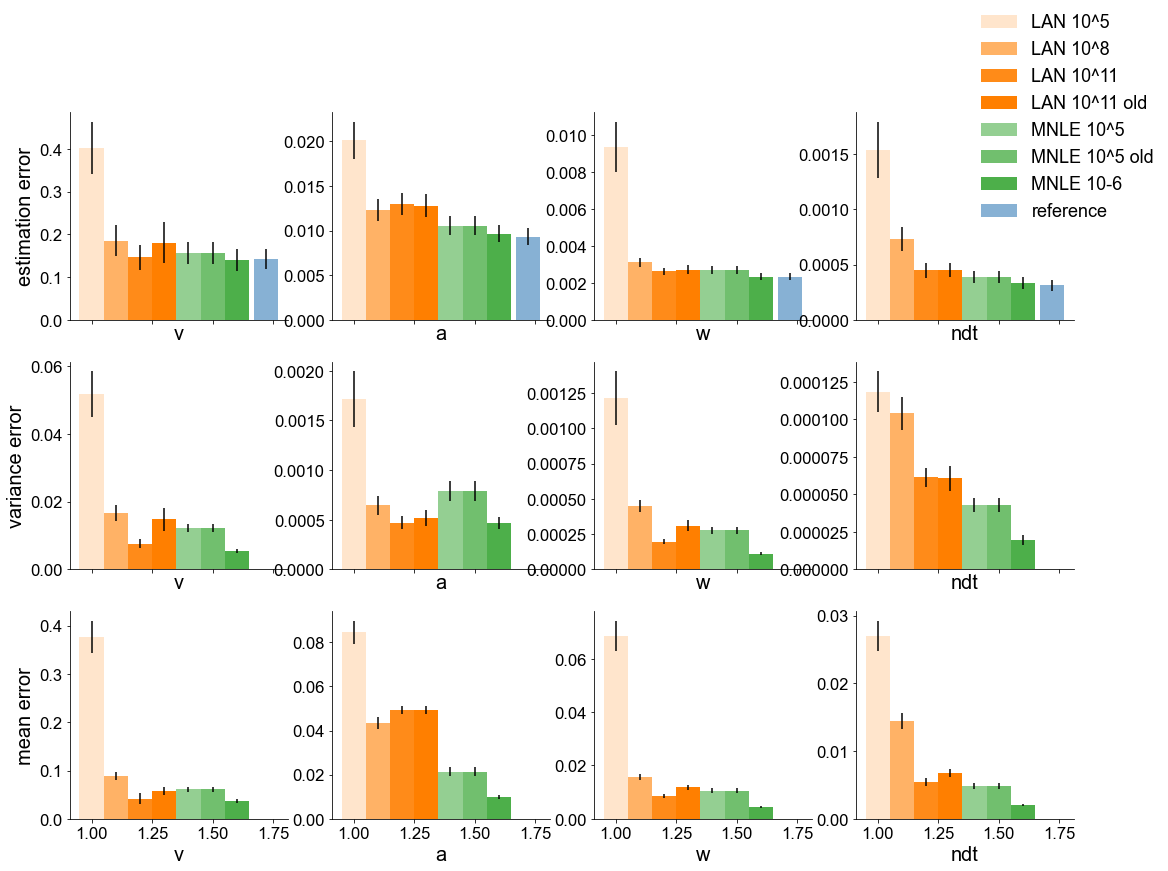

In [64]:
import numpy as np
fig, ax = plt.subplots(3, 4, figsize=(18, 13), sharey=False, sharex=True)
xlabels = ["v", "a", "w", "ndt"]
ylabels = ["mean error", "variance error", "estimation error"]
width = 0.1
pos = 1.

for jj in range(3):  # metrics
    for ii in range(4):  # params
        plt.sca(ax[-jj-1, ii])
        plot_bar(pos, metrics_lan_5[:, jj, ii], label="LAN 10^5", color=colors[1], alpha=0.2)
        plot_bar(pos+0.1, metrics_lan_8[:, jj, ii], label="LAN 10^8", color=colors[1], alpha=0.6)
        plot_bar(pos+0.2, metrics_lan_11[:, jj, ii], label="LAN 10^11", color=colors[1], alpha=.9)
        plot_bar(pos+0.3, metrics_lan_11_old[:, jj, ii], label="LAN 10^11 old", color=colors[1], alpha=1)
        plot_bar(pos+0.4, metrics_mnle_5[:, jj, ii], label="MNLE 10^5", color=colors[2], alpha=.6)
        plot_bar(pos+0.5, metrics_mnle_5[:, jj, ii], label="MNLE 10^5 old", color=colors[2], alpha=.8)
        plot_bar(pos+0.6, metrics_mnle_6[:, jj, ii], label="MNLE 10-6", color=colors[2], alpha=1.0)
        if jj==2:
            plot_bar(pos+0.72, metrics_lan_11[:, jj+1, ii], label="reference", color=colors[0])
        # plt.xticks([])
        plt.xlabel(xlabels[ii])
        if ii==3 and jj==2:
            plt.legend(
                bbox_to_anchor=(.5, .4)
                )
        if ii==0:
            plt.ylabel(ylabels[jj])

/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],


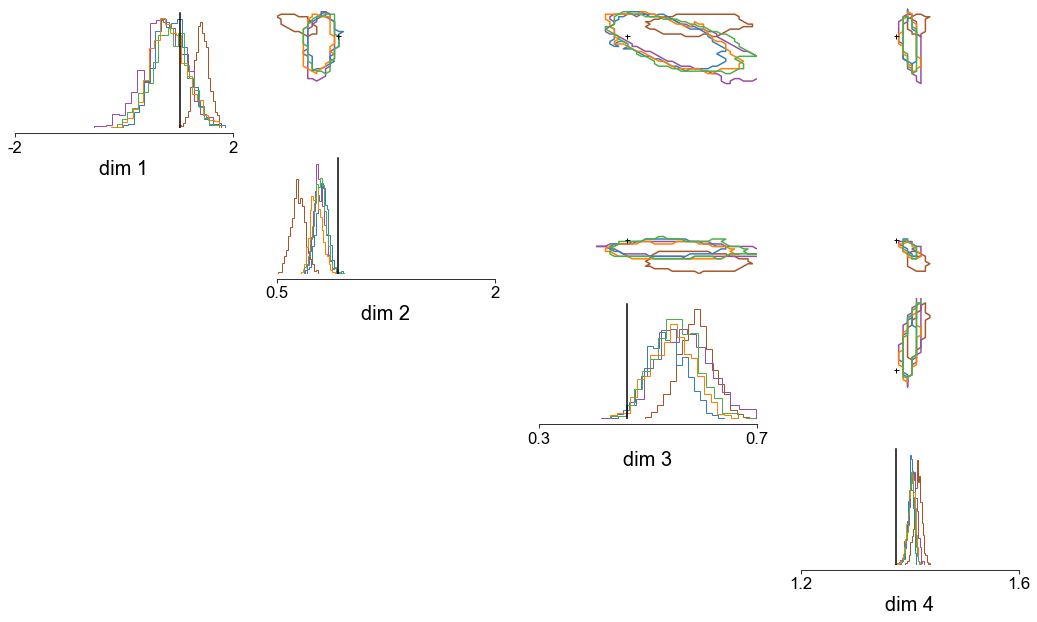

In [10]:
# Reference posterior for first obs in xos
obsi = 1
reference_samples = task.get_reference_posterior_samples(201+obsi)
true_theta = task.get_true_parameters(201+obsi)

fig, ax = pairplot(
    [
        
        samples_lan_5[obsi,],
        samples_lan_8[obsi,],
        reference_samples[:1000], 
        samples_lan_11[obsi,],
        samples_mnle_5[obsi,],
    ], 
    samples_colors = colors[4:6] + colors[:3],
    upper="contour", 
    diag="hist",
    points=[true_theta], 
    points_offdiag=dict(marker="+", markersize=5),
    points_colors=["k"],
    figsize=(18, 10),
    hist_diag=dict(bins=20),
    contour_offdiag = dict(levels=[0.99]),
    limits=[[-2, 2], [0.5, 2.0], [.3, .7], [1.2, 1.6]], 
    ticks = [[-2, 2], [0.5, 2.0], [.3, .7], [1.2, 1.6]], 
);